<a href="https://colab.research.google.com/github/Francisco-Italo/ml2023-Italo-Moraes/blob/master/ml2023-Italo-Moraes/Freezing-of-gait-dt/FOG_pred_update.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# O presente modelo visa identificar a probabilidade de ocorrência de um indivíduo ter manifestado um evento de congelamento da marcha - ou do andar - (FOG, do inglês "freezing of gait"), que são: hesitação ao iniciar uma caminhada, dificuldade em fazer uma curva, e parada brusca enquanto caminha.
# O dataset contém os a seguintes colunas:

*   Time: Timestamp do registro.
*   AccV: valor do acelerômetro no eixo vertical.
*   AccML: valor do acelerômetro no eixo meio-lateral.
*   AccAP: valor do acelerômetro no eixo anteroposterior.
*   StartHesitation: Dificuldade em começar uma caminhada.
*   Turn: Dificuldade em fazer uma curva.
*   Walking: Parada brusca na caminhada.
*   Valid: Marcado como False se não há certeza da detecção do evento.
*   Task: Anotações registradas pelos pesquisadores.



In [1]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math
import glob
import os

## Armazenamento de dados em dois datasets: treino e teste. Como o dataset de treino contém 3 outros subdiretórios, optou-se por retirar um subdiretório, que contém uma coluna diferente dos outros dois subdiretórios, além de conter menos atributos.

In [2]:
def join_dfs(dir_path):
  subfolders = [f.path for f in os.scandir(dir_path) if f.is_dir()]

  dataframes = []
  # Subdiretório que será retirado
  black_sheep = 'notype'
  # Neste subdiretório, os dados dos subdiretórios estão em g, por isso,
  # será efetuada a conversão de escala, de g para m/s^2
  need_convertion = 'defog'

  for sf in subfolders:
    if black_sheep in sf: continue

    pat = os.path.join(sf, '*.csv')
    f_list = glob.glob(pat)

    i = 0
    for file in f_list:
      if i == 20: break

      df = pd.read_csv(file)
      # Conversão de g para m/s^2
      if need_convertion in sf: df = df.applymap(lambda x: x * 9.8 if pd.api.types.is_float_dtype(x) else x)
      dataframes.append(df)
      i = i+1

  return dataframes

In [3]:
dir_path = '/content/drive/MyDrive/FOG-dataset/train/'
df_train = pd.concat(join_dfs(dir_path), axis=0, ignore_index=True)

dir_path = '/content/drive/MyDrive/FOG-dataset/test/'
df_test = pd.concat(join_dfs(dir_path), axis=0, ignore_index=True)

## Análise dos dados



In [4]:
df_train.head()

,Time,AccV,AccML,AccAP,StartHesitation,Turn,Walking,Valid,Task
0,0,-8.934903,-0.045351,-3.295116,0,0,0,NaN,NaN
1,1,-8.921293,-0.050063,-3.304153,0,0,0,NaN,NaN
2,2,-8.922881,-0.040125,-3.311976,0,0,0,NaN,NaN
3,3,-8.933698,-0.030371,-3.313792,0,0,0,NaN,NaN
4,4,-8.938324,-0.023556,-3.304763,0,0,0,NaN,NaN


In [5]:
df_test.head()

,Time,AccV,AccML,AccAP
0,0,-9.533939,0.566322,-1.413525
1,1,-9.536140,0.564137,-1.440621
2,2,-9.529345,0.561765,-1.429332
3,3,-9.531239,0.564227,-1.415490
4,4,-9.540825,0.561854,-1.429471


## Bateria de verificações:


1.   Formato do dataset
2.   Informações dos dados do dataset
3.   Colunas do dataset
4.   Tipos dos dados por coluna
5.   Contagem de dados faltantes
6.   Contagem de valores assinalados como verdadeiro e falso (apenas colunas Valid e Task)

## Ambas verificações valem para treino e teste


In [6]:
print(f"DataFrame shape : {df_train.shape}\n=================================")
print(f"DataFrame info : {df_train.info()}\n=================================")
print(f"DataFrame columns : {df_train.columns}\n=================================")
print(f"The type of each column : {df_train.dtypes}\n=================================")
print(f"How much missing value in every column : {df_train.isna().sum()}\n=================================")
print(f"True counts : {(df_train[['Valid','Task']] == True).sum()}\n=================================")
print(f"False counts : {(df_train[['Valid','Task']] == False).sum()}\n=================================")

DataFrame shape : (3213909, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3213909 entries, 0 to 3213908
Data columns (total 9 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Time             int64  
 1   AccV             float64
 2   AccML            float64
 3   AccAP            float64
 4   StartHesitation  int64  
 5   Turn             int64  
 6   Walking          int64  
 7   Valid            object 
 8   Task             object 
dtypes: float64(3), int64(4), object(2)
memory usage: 220.7+ MB
DataFrame info : None
DataFrame columns : Index(['Time', 'AccV', 'AccML', 'AccAP', 'StartHesitation', 'Turn', 'Walking',
       'Valid', 'Task'],
      dtype='object')
The type of each column : Time                 int64
AccV               float64
AccML              float64
AccAP              float64
StartHesitation      int64
Turn                 int64
Walking              int64
Valid               object
Task                object
dtype: object
How much mis

### Mudança das colunas do tipo 'object' para 'bool'

In [7]:
df_train.replace({'false':False,'true':True})
df_train.fillna(True)

,Time,AccV,AccML,AccAP,StartHesitation,Turn,Walking,Valid,Task
0,0,-8.934903,-0.045351,-3.295116,0,0,0,True,True
1,1,-8.921293,-0.050063,-3.304153,0,0,0,True,True
2,2,-8.922881,-0.040125,-3.311976,0,0,0,True,True
3,3,-8.933698,-0.030371,-3.313792,0,0,0,True,True
4,4,-8.938324,-0.023556,-3.304763,0,0,0,True,True
...,...,...,...,...,...,...,...,...,...
3213904,125350,-1.000000,-0.046875,-0.296875,0,0,0,False,False
3213905,125351,-1.000000,-0.046875,-0.296875,0,0,0,False,False
3213906,125352,-1.000000,-0.046875,-0.296875,0,0,0,False,False
3213907,125353,-1.000000,-0.046875,-0.296875,0,0,0,False,False


In [8]:
df_train['Valid'] = df_train['Valid'].astype(bool)
df_train['Task'] = df_train['Task'].astype(bool)

In [9]:
df_train

,Time,AccV,AccML,AccAP,StartHesitation,Turn,Walking,Valid,Task
0,0,-8.934903,-0.045351,-3.295116,0,0,0,True,True
1,1,-8.921293,-0.050063,-3.304153,0,0,0,True,True
2,2,-8.922881,-0.040125,-3.311976,0,0,0,True,True
3,3,-8.933698,-0.030371,-3.313792,0,0,0,True,True
4,4,-8.938324,-0.023556,-3.304763,0,0,0,True,True
...,...,...,...,...,...,...,...,...,...
3213904,125350,-1.000000,-0.046875,-0.296875,0,0,0,False,False
3213905,125351,-1.000000,-0.046875,-0.296875,0,0,0,False,False
3213906,125352,-1.000000,-0.046875,-0.296875,0,0,0,False,False
3213907,125353,-1.000000,-0.046875,-0.296875,0,0,0,False,False


### Reverificação

In [10]:
print(f"DataFrame shape : {df_train.shape}\n=================================")
print(f"DataFrame info : {df_train.info()}\n=================================")
print(f"DataFrame columns : {df_train.columns}\n=================================")
print(f"The type of each column : {df_train.dtypes}\n=================================")
print(f"How much missing value in every column : {df_train.isna().sum()}\n=================================")
print(f"True counts : {(df_train[['Valid','Task']] == True).sum()}\n=================================")
print(f"False counts : {(df_train[['Valid','Task']] == False).sum()}\n=================================")

DataFrame shape : (3213909, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3213909 entries, 0 to 3213908
Data columns (total 9 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Time             int64  
 1   AccV             float64
 2   AccML            float64
 3   AccAP            float64
 4   StartHesitation  int64  
 5   Turn             int64  
 6   Walking          int64  
 7   Valid            bool   
 8   Task             bool   
dtypes: bool(2), float64(3), int64(4)
memory usage: 177.8 MB
DataFrame info : None
DataFrame columns : Index(['Time', 'AccV', 'AccML', 'AccAP', 'StartHesitation', 'Turn', 'Walking',
       'Valid', 'Task'],
      dtype='object')
The type of each column : Time                 int64
AccV               float64
AccML              float64
AccAP              float64
StartHesitation      int64
Turn                 int64
Walking              int64
Valid                 bool
Task                  bool
dtype: object
How much missin

In [11]:
print(f"DataFrame shape : {df_test.shape}\n=================================")
print(f"DataFrame info : {df_test.info()}\n=================================")
print(f"DataFrame columns : {df_test.columns}\n=================================")
print(f"The type of each column : {df_test.dtypes}\n=================================")
print(f"How much missing value in every column : {df_test.isna().sum()}\n=================================")

DataFrame shape : (286370, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286370 entries, 0 to 286369
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    286370 non-null  int64  
 1   AccV    286370 non-null  float64
 2   AccML   286370 non-null  float64
 3   AccAP   286370 non-null  float64
dtypes: float64(3), int64(1)
memory usage: 8.7 MB
DataFrame info : None
DataFrame columns : Index(['Time', 'AccV', 'AccML', 'AccAP'], dtype='object')
The type of each column : Time       int64
AccV     float64
AccML    float64
AccAP    float64
dtype: object
How much missing value in every column : Time     0
AccV     0
AccML    0
AccAP    0
dtype: int64


In [12]:
df_test

,Time,AccV,AccML,AccAP
0,0,-9.533939,0.566322,-1.413525
1,1,-9.536140,0.564137,-1.440621
2,2,-9.529345,0.561765,-1.429332
3,3,-9.531239,0.564227,-1.415490
4,4,-9.540825,0.561854,-1.429471
...,...,...,...,...
286365,281683,-0.899299,-0.232668,0.389147
286366,281684,-0.901973,-0.233051,0.390114
286367,281685,-0.901690,-0.231888,0.391896
286368,281686,-0.899576,-0.232429,0.391106


### Cálculos de:


1.   Média
2.   Desvio padrão
3.   Valores mínimo e máximo

### Os cálculos foram submetidos apenas aos valores dos acelerômetros

Vertical reading Mean:  -1.3131349028741435
Vertical reading  Standard Deviation:  1.7387212666056044
Vertical reading  Minimum:  -25.1512224620068
Vertical reading  Maximum:  1.46351889198778

Mediolaeral reading Mean:  0.001206769320942131
Mediolaeral reading  Standard Deviation:  0.2603966551395825
Mediolaeral reading  Minimum:  -19.8373213894814
Mediolaeral reading  Maximum:  24.5404936985729

Anteroposterior reading Mean:  -0.0662818297175482
Anteroposterior reading  Standard Deviation:  0.7322750265891638
Anteroposterior reading  Minimum:  -20.5346097807998
Anteroposterior reading  Maximum:  14.5238525804835


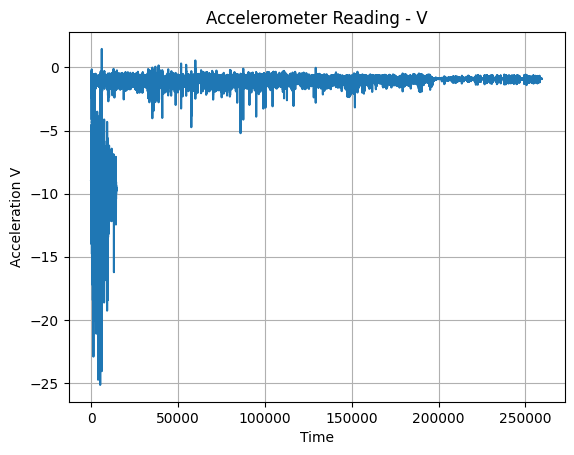

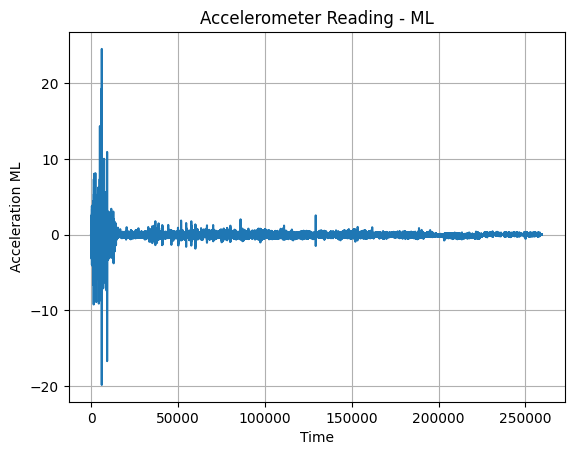

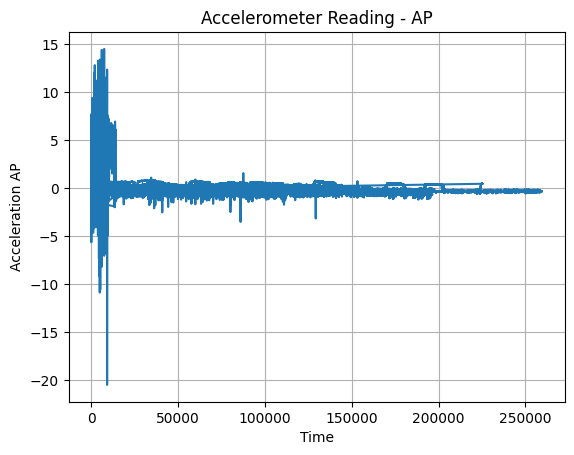

"\nfig = plt.figure()\nax = plt.axes(projection='3d')\n\nax.scatter3D(df_train['AccV'], df_train['AccML'], df_train['AccAP'])\n\nax.set_xlabel('AccV')\nax.set_ylabel('AccML')\nax.set_zlabel('AccAP')\nax.set_title('Accelerometer Values')\n\nplt.show()\n"

In [13]:
# Média
mean_value = df_train['AccV'].mean()

# Desvio padrão
std_deviation = df_train['AccV'].std()

# Mínimo valor encontrado
min_value = df_train['AccV'].min()

# Máximo valor encontrado
max_value = df_train['AccV'].max()

print("Vertical reading Mean: ", mean_value)
print("Vertical reading  Standard Deviation: ", std_deviation)
print("Vertical reading  Minimum: ", min_value)
print("Vertical reading  Maximum: ", max_value)
print()

mean_value = df_train['AccML'].mean()

std_deviation = df_train['AccML'].std()

min_value = df_train['AccML'].min()

max_value = df_train['AccML'].max()

print("Mediolaeral reading Mean: ", mean_value)
print("Mediolaeral reading  Standard Deviation: ", std_deviation)
print("Mediolaeral reading  Minimum: ", min_value)
print("Mediolaeral reading  Maximum: ", max_value)
print()

mean_value = df_train['AccAP'].mean()

std_deviation = df_train['AccAP'].std()

min_value = df_train['AccAP'].min()

max_value = df_train['AccAP'].max()

print("Anteroposterior reading Mean: ", mean_value)
print("Anteroposterior reading  Standard Deviation: ", std_deviation)
print("Anteroposterior reading  Minimum: ", min_value)
print("Anteroposterior reading  Maximum: ", max_value)

plt.figure()
plt.plot(df_train['Time'], df_train['AccV'])
plt.xlabel('Time')
plt.ylabel('Acceleration V')
plt.title('Accelerometer Reading - V')
plt.grid(True)
plt.show()

# Plotting Acceleration Y
plt.figure()
plt.plot(df_train['Time'], df_train['AccML'])
plt.xlabel('Time')
plt.ylabel('Acceleration ML')
plt.title('Accelerometer Reading - ML')
plt.grid(True)
plt.show()

# Plotting Acceleration Z
plt.figure()
plt.plot(df_train['Time'], df_train['AccAP'])
plt.xlabel('Time')
plt.ylabel('Acceleration AP')
plt.title('Accelerometer Reading - AP')
plt.grid(True)
plt.show()

'''
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.scatter3D(df_train['AccV'], df_train['AccML'], df_train['AccAP'])

ax.set_xlabel('AccV')
ax.set_ylabel('AccML')
ax.set_zlabel('AccAP')
ax.set_title('Accelerometer Values')

plt.show()
'''

### Matriz de correlação:

1.   Em relação aos valores dos acelerômetros
2.   Em relação às anotações de confiabilidade da detecção dos eventos
3.   Em relação aos valores dos acelerômetros e às colunas de confiabilidade de detecção dos eventos



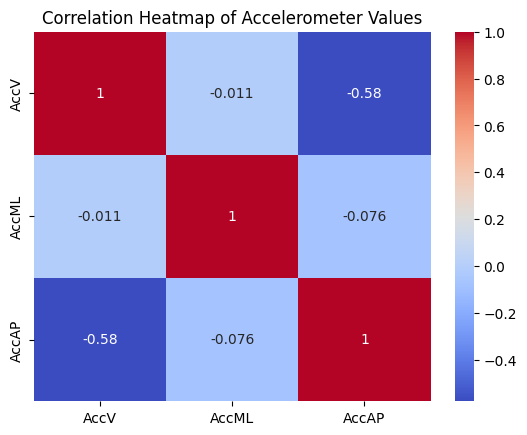

In [14]:
# Create a subset DataFrame with the accelerometer values
accelerometer_df = df_train[['AccV', 'AccML', 'AccAP']]

# Calculate the correlation matrix
correlation_matrix = accelerometer_df.corr()

# Create a heatmap
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")

# Set the plot title
plt.title("Correlation Heatmap of Accelerometer Values")

# Show the plot
plt.show()

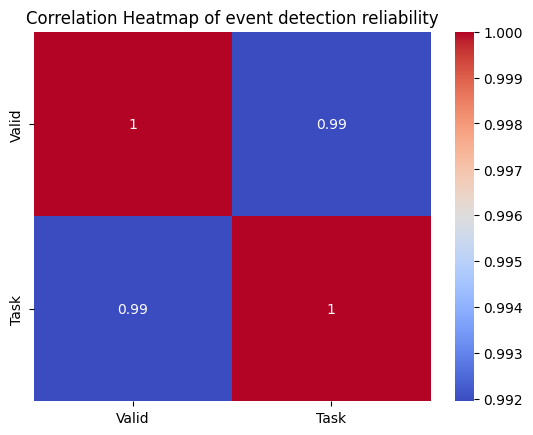

In [15]:
# Create a subset DataFrame with the accelerometer values
events_df = df_train[['Valid', 'Task']]

# Calculate the correlation matrix
correlation_matrix = events_df.corr()

# Create a heatmap
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")

# Set the plot title
plt.title("Correlation Heatmap of event detection reliability")

# Show the plot
plt.show()

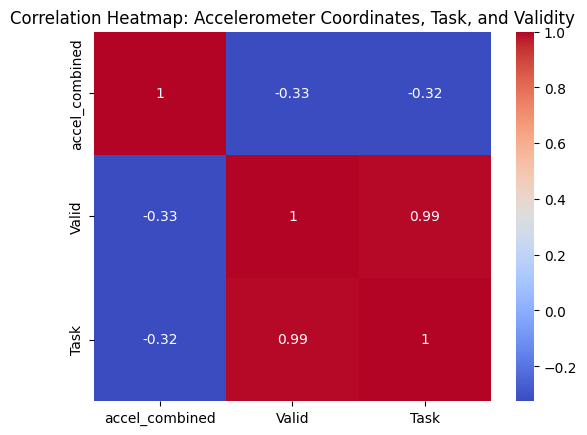

In [16]:
# Create a new column for combined accelerometer coordinates
df_train['accel_combined'] = df_train['AccV'] + df_train['AccML'] + df_train['AccAP']

# Create a subset DataFrame with the combined accelerometer coordinates, 'Task', and 'Valid' columns
subset_df = df_train[['accel_combined', 'Valid', 'Task']]

# Calculate the correlation matrix
correlation_matrix = subset_df.corr()

# Create a heatmap
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")

# Set the plot title
plt.title("Correlation Heatmap: Accelerometer Coordinates, Task, and Validity")

# Show the plot
plt.show()

### Contagem de valores das colunas:

*   StartHesitation
*   Turn
*   Walking



In [17]:
# Calculate the occurrence counts for each event in column 1
hesitation_count = df_train['StartHesitation'].value_counts()

# Calculate the occurrence counts for each event in column 2
turn_count = df_train['Turn'].value_counts()

# Calculate the occurrence counts for each event in column 3
walk_count = df_train['Walking'].value_counts()

# Print the values
print(hesitation_count)
print(turn_count)
print(walk_count)

0    3213761
1        148
Name: StartHesitation, dtype: int64
0    3061263
1     152646
Name: Turn, dtype: int64
0    3211834
1       2075
Name: Walking, dtype: int64


## Tratamento dos dados

### Normalização

In [18]:
norm_for_train = df_train[['AccV','AccML','AccAP']]

scaler = MinMaxScaler()
df_norm = pd.DataFrame(scaler.fit_transform(norm_for_train), columns=norm_for_train.columns)

df_train[df_norm.columns] = df_norm

In [19]:
df_train

,Time,AccV,AccML,AccAP,StartHesitation,Turn,Walking,Valid,Task,accel_combined
0,0,0.609298,0.445988,0.491736,0,0,0,True,True,-12.275370
1,1,0.609810,0.445882,0.491478,0,0,0,True,True,-12.275509
2,2,0.609750,0.446106,0.491255,0,0,0,True,True,-12.274982
3,3,0.609344,0.446325,0.491203,0,0,0,True,True,-12.277861
4,4,0.609170,0.446479,0.491460,0,0,0,True,True,-12.266643
...,...,...,...,...,...,...,...,...,...,...
3213904,125350,0.907438,0.445954,0.577257,0,0,0,False,False,-1.343750
3213905,125351,0.907438,0.445954,0.577257,0,0,0,False,False,-1.343750
3213906,125352,0.907438,0.445954,0.577257,0,0,0,False,False,-1.343750
3213907,125353,0.907438,0.445954,0.577257,0,0,0,False,False,-1.343750


In [20]:
df_train.shape

(3213909, 10)

In [21]:
df_train = df_train[df_train['Valid'] == True]
df_train.shape

(1048116, 10)

Se o histograma tiver uma forma de curva gaussiana, significa que os dados foram normalizados

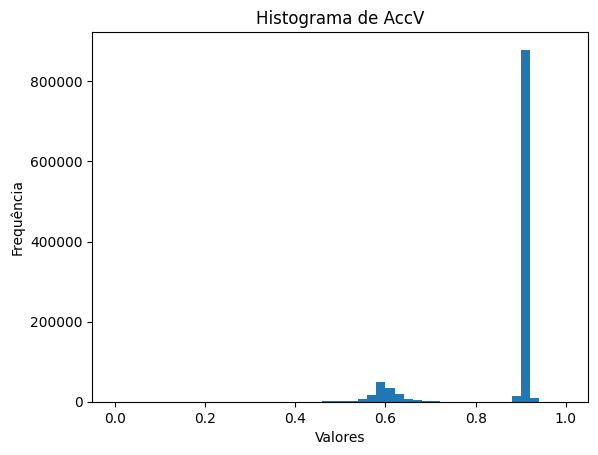

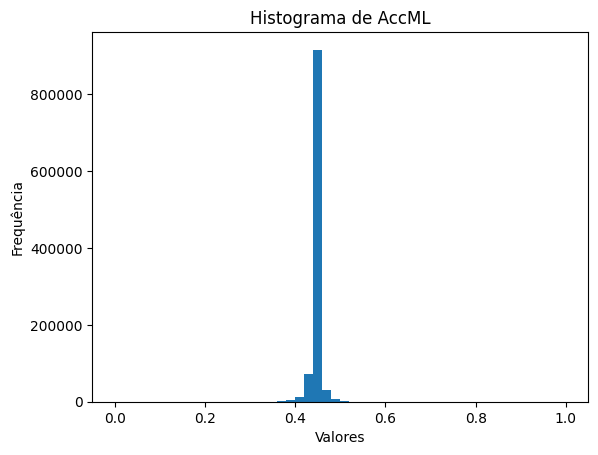

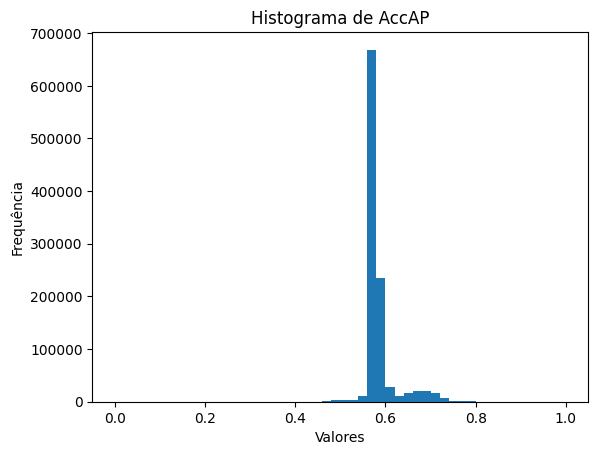

In [22]:
for column in norm_for_train.columns:
    plt.hist(df_train[column], bins=50)
    plt.title(f"Histograma de {column}")
    plt.xlabel("Valores")
    plt.ylabel("Frequência")
    plt.show()

Eliminação dos registros cuja coluna "Valid" são falsas, bem como a eliminação de colunas não necessárias para o treinamento

In [23]:
df_train = df_train.loc[df_train['Valid'] != False]
df_train.shape

(1048116, 10)

In [24]:
dropping = ['Task', 'Valid', 'accel_combined']
df_train = df_train.drop(dropping, axis=1)

In [25]:
df_train

,Time,AccV,AccML,AccAP,StartHesitation,Turn,Walking
0,0,0.609298,0.445988,0.491736,0,0,0
1,1,0.609810,0.445882,0.491478,0,0,0
2,2,0.609750,0.446106,0.491255,0,0,0
3,3,0.609344,0.446325,0.491203,0,0,0
4,4,0.609170,0.446479,0.491460,0,0,0
...,...,...,...,...,...,...,...
3212904,124350,0.911557,0.447710,0.576365,0,0,0
3212905,124351,0.912134,0.447346,0.576365,0,0,0
3212906,124352,0.912134,0.447002,0.576365,0,0,0
3212907,124353,0.912134,0.446317,0.576365,0,0,0


### Balanceamento do dataset de treino, de forma que há mesmo número de labels 1 e 0.

In [26]:
X_merged = df_train.iloc[:, 0:4]
y1 = df_train['StartHesitation']
y2 = df_train['Turn']
y3 = df_train['Walking']

In [27]:
# Posições em y1 onde há valor zero
y1_zeros = np.where(y1 == 0)[0]
# "                          " um
y1_ones = np.where(y1 == 1)[0]

# Seleção das amostras com valor um e zero de modo que haja o mesmo número de ambas
num1_ones = (y1 == 1).sum()
np.random.seed(42)
y1_zeros = np.random.choice(np.where(y1 == 0)[0], size = num1_ones, replace = False)

# Combinar as posições y1 == 1 e y1 == 0
y1_balanced_idxs = np.sort(np.concatenate([y1_zeros, y1_ones]))

# Uso dos índices do vetor balanceado para encontrar as linhas no vetor original
X1_balanced = X_merged.iloc[y1_balanced_idxs, :]
y1_balanced = y1.iloc[y1_balanced_idxs]

In [28]:
y2_zeros = np.where(y2 == 0)[0]
y2_ones = np.where(y2 == 1)[0]

num2_ones = (y2 == 1).sum()
np.random.seed(42)
y2_zeros = np.random.choice(np.where(y2 == 0)[0], size = num2_ones, replace = False)

y2_bal = np.sort(np.concatenate([y2_zeros, y2_ones]))

X2_balanced = X_merged.iloc[y2_bal, :]
y2_balanced = y2.iloc[y2_bal]

In [29]:
y3_zeros = np.where(y3 == 0)[0]
y3_ones = np.where(y3 == 1)[0]

num3_ones = (y3 == 1).sum()
np.random.seed(42)
y3_zeros = np.random.choice(np.where(y3 == 0)[0], size = num3_ones, replace = False)

y3_bal = np.sort(np.concatenate([y3_zeros, y3_ones]))

X3_balanced = X_merged.iloc[y3_bal, :]
y3_balanced = y3.iloc[y3_bal]

## Treinamento

## Separação dos dados entre treino e teste.
## Dataset de validação será referido como teste

In [30]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1_balanced, y1_balanced, test_size = 0.25, random_state = 42)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2_balanced, y2_balanced, test_size = 0.25, random_state = 42)
X3_train, X3_test, y3_train, y3_test = train_test_split(X3_balanced, y3_balanced, test_size = 0.25, random_state = 42)

### *Parameter tuning* para encontrar a melhor combinação de hiperparâmetros

In [31]:
lr_param_grid = {
    'fit_intercept': [True, False],
    'n_jobs': [-1],
    'copy_X': [True, False],
    'positive': [True, False]
}
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [8],
    'n_jobs': [-1],
    'random_state': [42]
}

model1 = GridSearchCV(RandomForestRegressor(), rf_param_grid, cv = 5)
model2 = GridSearchCV(RandomForestRegressor(), rf_param_grid, cv = 5)
model3 = GridSearchCV(RandomForestRegressor(), rf_param_grid, cv = 5)

model4 = GridSearchCV(LinearRegression(), lr_param_grid, cv = 5)
model5 = GridSearchCV(LinearRegression(), lr_param_grid, cv = 5)
model6 = GridSearchCV(LinearRegression(), lr_param_grid, cv = 5)

## Treinamento com a técnica de regressão linear
## As métricas de avaliação usadas foram as seguintes:


*   Erro Quadrático Médio (MSE - Mean Squared Error):
O MSE calcula a média dos quadrados das diferenças entre os valores previstos e os valores reais. Ele fornece uma medida geral da precisão das previsões do modelo. Um MSE menor indica um ajuste melhor entre as previsões do modelo e os valores reais.
*   Raiz do Erro Quadrático Médio (RMSE - Root Mean Squared Error):
O RMSE é a raiz quadrada do MSE. Ele fornece uma medida da magnitude média dos erros nas previsões. Assim como o MSE, um RMSE menor indica um ajuste melhor do modelo.
*   Erro Médio Absoluto (MAE - Mean Absolute Error):
O MAE calcula a média das diferenças absolutas entre os valores previstos e os valores reais. Da mesma forma que o MSE e o RMSE, um MAE menor indica um melhor desempenho do modelo.
*   R2: mede o quão preparado(*fittado*) o modelo está com os dados aos quais o modelo foi treinado

In [35]:
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}', xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), textcoords='offset points',
                    ha='center', va='bottom')

def plot_metrics(m1,m2,m3, opt):
    if opt == 1:
        metrics = ['MSE_y1','MSE_y2','MSE_y3']
    elif opt == 2:
        metrics = ['RMSE_y1','RMSE_y2','MSE_y3']
    else:
        metrics = ['MAE_y1','MAE_y2','MAE_y3']

    model_scores = [m1, m2, m3]

    x = np.arange(len(metrics))
    width = 0.35

    fig, ax = plt.subplots()
    rects = ax.bar(x - width/2, model_scores, width, label='Linear Regression')

    ax.set_xlabel('Metrics')
    ax.set_ylabel('Scores')
    ax.set_title('Comparison of Metrics for Linear Regression Model')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.legend()

    autolabel(rects)

    plt.tight_layout()
    plt.show()

## Treinamento usando as técnicas árvore aleatória regressora e regressão linear

In [33]:
model4.fit(X1_train, y1_train)
model5.fit(X2_train, y2_train)
model6.fit(X3_train, y3_train)

# Evaluate the models on the test data.
print('R2 for StartHesitation:', model4.best_score_)
print('R2 for Turn:', model5.best_score_)
print('R2 for Walking:', model6.best_score_)

# Print the best parameters for each model
print('Best parameters for StartHesitation:', model4.best_params_)
print('Best parameters for Turn:', model5.best_params_)
print('Best parameters for Walking:', model6.best_params_)

R2 for StartHesitation: 0.07163659741163553
R2 for Turn: 0.06649760691368083
R2 for Walking: 0.024868957412130112
Best parameters for StartHesitation: {'copy_X': True, 'fit_intercept': False, 'n_jobs': -1, 'positive': False}
Best parameters for Turn: {'copy_X': True, 'fit_intercept': True, 'n_jobs': -1, 'positive': False}
Best parameters for Walking: {'copy_X': True, 'fit_intercept': True, 'n_jobs': -1, 'positive': True}


NameError: ignored

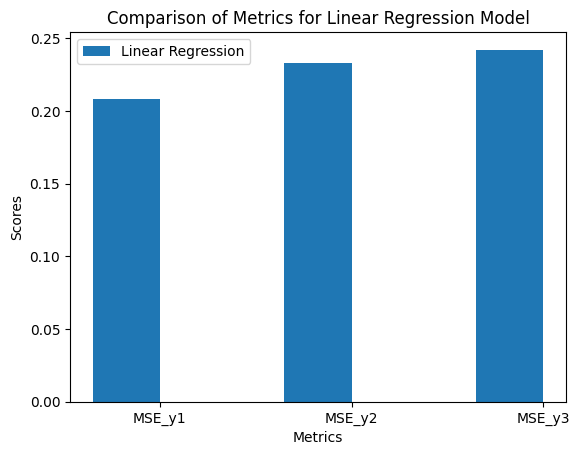

In [36]:
pred_y1 = model4.predict(X1_test)
pred_y2 = model5.predict(X2_test)
pred_y3 = model6.predict(X3_test)

mse_y1 = mean_squared_error(y1_test, pred_y1)
mse_y2 = mean_squared_error(y2_test, pred_y2)
mse_y3 = mean_squared_error(y3_test, pred_y3)

rmse_y1 = math.sqrt(mse_y1)
rmse_y2 = math.sqrt(mse_y2)
rmse_y3 = math.sqrt(mse_y3)

mae_y1 = mean_absolute_error(y1_test, pred_y1)
mae_y2 = mean_absolute_error(y2_test, pred_y2)
mae_y3 = mean_absolute_error(y3_test, pred_y3)

plot_metrics(mse_y1,mse_y2,mse_y3,1)
plot_metrics(rmse_y1,rmse_y2,rmse_y3,2)
plot_metrics(mae_y1,mae_y2,mae_y3,3)

In [ ]:
model1.fit(X1_train, y1_train)
model2.fit(X2_train, y2_train)
model3.fit(X3_train, y3_train)

# Evaluate the models on the test data.
print('R2 for StartHesitation:', model1.best_score_)
print('R2 for Turn:', model2.best_score_)
print('R2 for Walking:', model3.best_score_)

# Print the best parameters for each model
print('Best parameters for StartHesitation:', model1.best_params_)
print('Best parameters for Turn:', model2.best_params_)
print('Best parameters for Walking:', model3.best_params_)

In [ ]:
pred_y1 = model1.predict(X1_test)
pred_y2 = model2.predict(X2_test)
pred_y3 = model3.predict(X3_test)

mse_y1 = mean_squared_error(y1_test, pred_y1)
mse_y2 = mean_squared_error(y2_test, pred_y2)
mse_y3 = mean_squared_error(y3_test, pred_y3)

rmse_y1 = math.sqrt(mse_y1)
rmse_y2 = math.sqrt(mse_y2)
rmse_y3 = math.sqrt(mse_y3)

mae_y1 = mean_absolute_error(y1_test, pred_y1)
mae_y2 = mean_absolute_error(y2_test, pred_y2)
mae_y3 = mean_absolute_error(y3_test, pred_y3)

plot_metrics(mse_y1,mse_y2,mse_y3,1)
plot_metrics(rmse_y1,rmse_y2,rmse_y3,2)
plot_metrics(mae_y1,mae_y2,mae_y3,3)

# Próximos passos:

*   Aprimorar a forma de separação dos dados (Cumprido)
*   Construir algoritmos com configuração customizada para o problema (Cumprido)
*   Avaliar o desempenho com métricas diversas (Cumprido)

